# Caso de Estudio: Predicción del Precio del Oro con Redes LSTM

## 1. Descubrimiento del Caso de Negocio
Contexto del proyecto: Commodity Analytics busca predecir el precio del oro (XAU/USD) utilizando datos históricos y variables macroeconómicas para optimizar decisiones de inversión.

In [ ]:
# Instalación y carga de librerías necesarias
!pip install yfinance tensorflow keras sklearn matplotlib seaborn shap keract pandas numpy

## 2. Procesamiento de Datos

In [1]:

import yfinance as yf
import pandas as pd
import numpy as np

# Descargar datos históricos desde Yahoo Finance
oro = yf.download("GC=F", start="2010-01-01")
dxy = yf.download("DX-Y.NYB", start="2010-01-01")
bonos = yf.download("^TNX", start="2010-01-01")
tip = yf.download("TIP", start="2010-01-01")

# Unión de datasets
df = pd.concat([oro['Close'], dxy['Close'], bonos['Close'], tip['Close']], axis=1).dropna()
df.columns = ['Oro', 'DXY', 'Bonos', 'TIP']

# Características derivadas
df['Ratio_Oro_DXY'] = df['Oro'] / df['DXY']
df['Inflacion_implicita'] = df['TIP'].pct_change()
df['Tasa_real'] = df['Bonos'] - df['Inflacion_implicita']

# Variables técnicas
df['SMA200'] = df['Oro'].rolling(window=200).mean()
df['Bollinger_up'] = df['Oro'].rolling(window=20).mean() + 2*df['Oro'].rolling(window=20).std()
df['Bollinger_down'] = df['Oro'].rolling(window=20).mean() - 2*df['Oro'].rolling(window=20).std()

df = df.dropna()
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Oro,DXY,Bonos,TIP,Ratio_Oro_DXY,Inflacion_implicita,Tasa_real,SMA200,Bollinger_up,Bollinger_down
Date,,,,,,,,,,
2010-10-19,1335.099976,78.180000,2.475,78.09021,17.077257,0.000537,2.474463,1189.230999,1388.590284,1265.079699
2010-10-20,1343.300049,77.169998,2.470,78.06929,17.407025,-0.000268,2.470268,1190.358999,1386.895931,1273.864054
2010-10-21,1324.699951,77.419998,2.531,78.06929,17.110566,0.000000,2.531000,1191.391999,1385.475709,1278.734277
2010-10-22,1324.400024,77.470001,2.563,78.09021,17.095650,0.000268,2.562732,1192.334499,1384.112541,1283.107442
2010-10-25,1338.300049,77.099998,2.554,78.32769,17.357978,0.003041,2.550959,1193.360499,1383.037908,1288.412080


## 3. Preparación de secuencias para LSTM

In [3]:
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# — your data —
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df)

look_back = 90
horizon   = 5

# you can still build X/Y manually…
X, Y = [], []
for i in range(len(data_scaled) - look_back - horizon):
    X.append(data_scaled[i : i + look_back])
    Y.append(data_scaled[i + look_back : i + look_back + horizon, 0])

X, Y = np.array(X), np.array(Y)
print(X.shape, Y.shape)

# …or use TimeseriesGenerator to do exactly that:
gen = TimeseriesGenerator(
    data_scaled,                  # full multivariate array
    data_scaled[:, 0],            # target series (gold price)
    length=look_back,
    sampling_rate=1,
    stride=1,
    start_index=0,
    end_index=None,
    shuffle=False,
    reverse=False,
    batch_size=32
)
# then iterate gen to get (X_batch, Y_batch)


(3551, 90, 10) (3551, 5)


## 4. División de los Datos en Train/Test

In [4]:

split_train = int(len(X) * 0.7)
split_val = int(len(X) * 0.85)

X_train, Y_train = X[:split_train], Y[:split_train]
X_val, Y_val = X[split_train:split_val], Y[split_train:split_val]
X_test, Y_test = X[split_val:], Y[split_val:]


## 5. Modelo LSTM

In [5]:

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(192, return_sequences=True, input_shape=(look_back, X.shape[2])),
    Dropout(0.35),
    LSTM(96),
    Dense(horizon)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 192)        │       155,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,365 (1.02 MB)

 Trainable params: 267,365 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Entrenamiento del Modelo

In [6]:

history = model.fit(X_train, Y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, Y_val))


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.0307 - mae: 0.1179 - val_loss: 0.0303 - val_mae: 0.1378
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0050 - mae: 0.0534 - val_loss: 0.0258 - val_mae: 0.1324
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0047 - mae: 0.0518 - val_loss: 0.0235 - val_mae: 0.1211
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0040 - mae: 0.0470 - val_loss: 0.0195 - val_mae: 0.1075
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0041 - mae: 0.0473 - val_loss: 0.0143 - val_mae: 0.0943
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0037 - mae: 0.0450 - val_loss: 0.0254 - val_mae: 0.1258
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.0036 - mae: 0.0444 - val_loss: 0.0169 - val_mae: 0.1031
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.0032 - mae: 0.0426 - val_loss: 0.0182 - val_mae: 0.1028
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0

## 7. Evaluación y Visualización

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


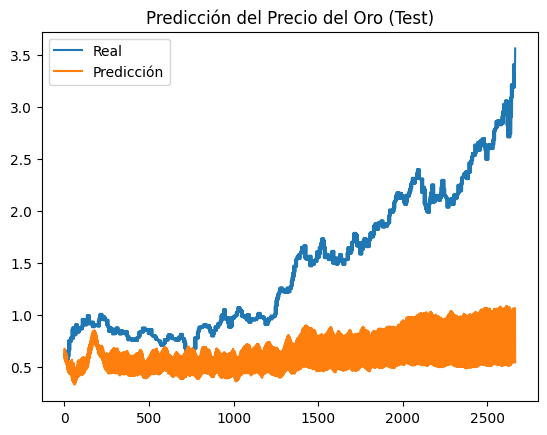

In [7]:

import matplotlib.pyplot as plt

preds = model.predict(X_test)
plt.plot(Y_test.flatten(), label='Real')
plt.plot(preds.flatten(), label='Predicción')
plt.legend()
plt.title('Predicción del Precio del Oro (Test)')
plt.show()


## 8. Interpretabilidad con SHAP (Opcional)

In [9]:
import shap
explainer = shap.GradientExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:10])
shap.summary_plot(shap_values, X_test[:10])


c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(10, 90, 10))']
  warnings.warn(msg)
c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 90, 10))']
  warnings.warn(msg)


StagingError: in user code:

    File "c:\Users\Alumno_AI\carlos\practicas\recurrentes\.venv\Lib\site-packages\shap\explainers\_gradient.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, x)

    LookupError: gradient registry has no entry for: shap_StridedSlice


## 9. Guardar el Modelo

In [ ]:

model.save('modelo_oro_lstm.h5')
import joblib
joblib.dump(scaler, 'scaler_robust.pkl')
